#Brain tumor classification with Neural Network

This Colab is the developement of Neural Network from scratch and applied it for classifying of CT-scan immages of brain tumor.

Reference data : https://www.kaggle.com/awsaf49/brain-tumor?select=brain_tumor_dataset

# Libralies

In [ ]:
#Neccessary library

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Prepare picture dataset from local storage

In [ ]:
# Load file .h5 with python

dataset_input = h5py.File("images_dataset.h5", "r")
print("Keys: %s" % dataset_input.keys())

train_set = np.array(list(dataset_input['x_train']))
test_set = np.array(list(dataset_input['x_test']))
train_predicted = np.array(list(dataset_input['y_train']))
test_predicted  = np.array(list(dataset_input['y_test']))

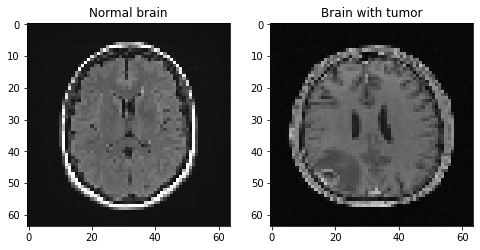

In [ ]:
# Example of train set

index1 = 122
index2 = 77
fig, axs = plt.subplots(1,2, figsize=(8, 8))
axs[0].set_title('Normal brain')
axs[0].imshow(train_set[index1])
axs[1].set_title('Brain with tumor')
axs[1].imshow(train_set[index2])

In [ ]:
# Dimension of data set

m_train = train_set.shape[0]
m_test = test_set.shape[0]
pixel = train_set[0].shape[0]

print("A number of train images is " + str(m_train))
print("A number of test images is " + str(m_test))
print("Resolution of each image is " + str(pixel) + "*" + str(pixel))

A number of train images is 176
A number of test images is 51
Resolution of each image is 64*64


In [ ]:
# reduce dimension and flattern 

X_train = train_set.reshape(train_set.shape[0],-1).T/255.
X_test = test_set.reshape(test_set.shape[0],-1).T/255.
Y_train = train_predicted.T
Y_test = test_predicted.T

print(str(X_train.shape))
print(str(X_test.shape))
print(str(Y_train.shape))
print(str(Y_test.shape))

(12288, 176)
(12288, 51)
(1, 176)
(1, 51)


# Model

In [ ]:
def sigmoid(Z):
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):

    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):

    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def initialize_parameters(n_x, n_h, n_y):

    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters     


def initialize_parameters_deep(layer_dims):
  
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):


    caches = []
    A = X
    L = len(parameters) // 2                  
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

def compute_cost(AL, Y):

    
    m = Y.shape[1]

   
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      
    assert(cost.shape == ())
    
    return cost

def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
   
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def predict(X, y, parameters):
   
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1, m),dtype=int)
    
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: %s" % str(np.sum(p == y)/float(m)))
        
    return p


In [ ]:
# n_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, print_cost):
   
    np.random.seed(1)
    costs = []                         
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


# Model setting and prediction

In [ ]:
# Deep neural network construction 
input_layer = X_train.shape[0]
output_layer = Y_train.shape[0]

layers_dims = [input_layer,30,20,output_layer] 

Cost after iteration 0: 0.663101
Cost after iteration 100: 0.195090
Cost after iteration 200: 0.141178
Cost after iteration 300: 0.029322
Cost after iteration 400: 0.007150
Cost after iteration 500: 0.003568
Cost after iteration 600: 0.002251
Cost after iteration 700: 0.001601
Cost after iteration 800: 0.001225
Cost after iteration 900: 0.000983
Cost after iteration 1000: 0.000815
Cost after iteration 1100: 0.000694
Cost after iteration 1200: 0.000602
Cost after iteration 1300: 0.000529
Cost after iteration 1400: 0.000471
Cost after iteration 1500: 0.000424
Cost after iteration 1600: 0.000385
Cost after iteration 1700: 0.000351
Cost after iteration 1800: 0.000323
Cost after iteration 1900: 0.000299
Cost after iteration 2000: 0.000277
Cost after iteration 2100: 0.000259
Cost after iteration 2200: 0.000242
Cost after iteration 2300: 0.000228
Cost after iteration 2400: 0.000215
Cost after iteration 2500: 0.000203
Cost after iteration 2600: 0.000192
Cost after iteration 2700: 0.000183
Cost

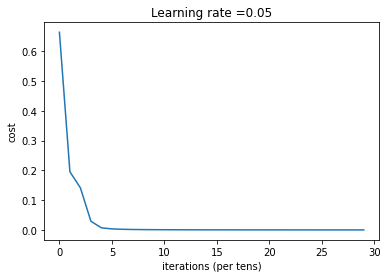

In [ ]:
# Set model
train_x = X_train
train_y = Y_train
layers_dims = layers_dims
learning_rate = 0.05
num_iterations = 3000

parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate, num_iterations, print_cost=True)

In [ ]:
# test model
test_x = X_test
test_y = Y_test

pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.7647058823529411


In [ ]:
predicted_result = {}
wrong_index = {}

n = probability.shape[1]

for i in range(0,n):
    check = p.T[i] == Y_test.T[i]
    
    if check == True:
        predicted_result[i] = 'Correct'
    else:
        predicted_result[i] = 'Wrong'

result = list(predicted_result.values())

k = 0

for i in range(0,n):
    print("index " +str(i)+ " Result " + result[i])
    
    if result[i] == "Wrong":
        index = i
        wrong_index[k] = index
        k = k+1

wrong_index = list(wrong_index.values())

index 0 Result Correct
index 1 Result Correct
index 2 Result Correct
index 3 Result Correct
index 4 Result Correct
index 5 Result Correct
index 6 Result Correct
index 7 Result Correct
index 8 Result Wrong
index 9 Result Correct
index 10 Result Correct
index 11 Result Correct
index 12 Result Correct
index 13 Result Correct
index 14 Result Correct
index 15 Result Correct
index 16 Result Correct
index 17 Result Correct
index 18 Result Correct
index 19 Result Correct
index 20 Result Wrong
index 21 Result Correct
index 22 Result Correct
index 23 Result Correct
index 24 Result Correct
index 25 Result Wrong
index 26 Result Correct
index 27 Result Wrong
index 28 Result Wrong
index 29 Result Wrong
index 30 Result Wrong
index 31 Result Correct
index 32 Result Correct
index 33 Result Correct
index 34 Result Wrong
index 35 Result Correct
index 36 Result Correct
index 37 Result Correct
index 38 Result Correct
index 39 Result Correct
index 40 Result Wrong
index 41 Result Correct
index 42 Result Wron

# Summary 

In [ ]:
n_wrong = len(wrong_index)
n_correct = n - len(wrong_index)
Acc = (n_correct/n)*100

print(Acc)

76.47058823529412


In [ ]:
n_wrong = len(wrong_index)
n_correct = n - len(wrong_index)
Acc = (n_correct/n)*100
print("Total test images : " + str(n))
print("Corrected prediction : " + str(n_correct))
print("Missed prediction : " + str(n_wrong))
print("Model accuration "+ str(Acc) + "%")


Total test images : 51
Corrected prediction : 39
Missed prediction : 12
Model accuration 76.47058823529412%
